In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import arviz as az

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
pd.set_option("precision", 2)

### Exercise 1

Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:

In [ ]:
data = [['Island 1', 0.2, 0.2, 0.2, 0.2, 0.2], ['Island 2', 0.8, 0.1, 0.05, 0.025, 0.025], ['Island 3', 0.05, 0.15, 0.7, 0.05, 0.05]] 
df = pd.DataFrame(data, columns = ['Island', 'Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'])
df.set_index("Island", inplace=True)
df

,Bird A,Bird B,Bird C,Bird D,Bird E
Island,,,,,
Island 1,0.20,0.20,0.20,0.20,0.20
Island 2,0.80,0.10,0.05,0.03,0.03
Island 3,0.05,0.15,0.70,0.05,0.05


In [ ]:
df.columns

Index(['Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'], dtype='object')

In [ ]:
cols = ['Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E']
df["entropy"] = df["Bird A"] * np.log(df["Bird A"]) + \
                df["Bird B"] * np.log(df["Bird B"]) + \
                df["Bird C"] * np.log(df["Bird C"]) + \
                df["Bird D"] * np.log(df["Bird D"]) + \
                df["Bird E"] * np.log(df["Bird E"])

In [ ]:
df["entropy"] = df["entropy"] * -1
df

,Bird A,Bird B,Bird C,Bird D,Bird E,entropy
Island,,,,,,
Island 1,0.20,0.20,0.20,0.20,0.20,1.61
Island 2,0.80,0.10,0.05,0.03,0.03,0.74
Island 3,0.05,0.15,0.70,0.05,0.05,0.98


In [ ]:
x = np.linspace(0, 1, 1000)
y = - x * np.log(x)

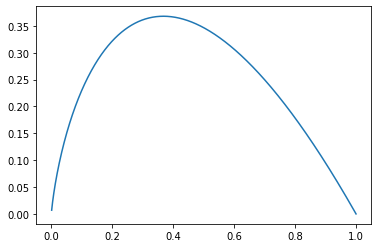

In [ ]:
plt.plot(x,y)

In [ ]:
cols = ['Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E']
def kl_distance(p, q):
    distance = (df.loc[p, cols] * 
                (np.log(df.loc[p, cols]) - 
                 np.log(df.loc[q, cols])))
    return distance.sum().round(2)

In [ ]:
kl_distance("Island 1", "Island 2"), kl_distance("Island 3", "Island 2")

(0.97, 1.84)

In [ ]:
kl_distance("Island 2", "Island 1"), kl_distance("Island 3", "Island 1")

(0.87, 0.63)

In [ ]:
kl_distance("Island 1", "Island 3"), kl_distance("Island 2", "Island 3")

(0.64, 2.01)

## Exercise 2

In [ ]:
d = pd.read_csv('data/happiness.csv', header=0)
d.head()

,age,married,happiness
0,65,0,-2.00
1,65,0,-1.79
2,65,1,-1.58
3,65,0,-1.37
4,65,0,-1.16


In [ ]:
d = d.loc[d.age > 17,]
d['age'] = ( d['age'] - 18 ) / ( 65 - 18 )

In [ ]:
# married = theano.shared(np.array(d.married))

In [ ]:
mid = pd.Categorical(d.married)
mid

[0, 0, 1, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 960
Categories (2, int64): [0, 1]

In [ ]:
# Model 6.9 from the book:
mid
with pm.Model() as model_69:
    # Data
    age = pm.Data("age", d["age"].values)
    happiness = pm.Data("happiness", d["happiness"].values)
    # Prior
    a = pm.Normal("a", mu=0, sd=1, shape=2)
    bA = pm.Normal("bA", mu=0, sd=2)
    sigma = pm.Exponential("sigma", lam=1)
    # Regression
    mu = a[mid] + bA * age
    happy_hat = pm.Normal("happy_hat", mu=mu, sd=sigma, observed=happiness)
    # Sampling
    prior_69 = pm.sample_prior_predictive(samples=30)
    trace_69 = pm.sample()
    posterior_69 = pm.sample_posterior_predictive(trace_69)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [ ]:
az.summary(trace_69, credible_interval=0.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.23,0.06,-0.35,-0.11,0.0,0.0,1909.0,1909.0,1911.0,1957.0,1.0
a[1],1.26,0.09,1.10,1.42,0.0,0.0,2069.0,2069.0,2071.0,2297.0,1.0
bA,-0.75,0.12,-0.96,-0.53,0.0,0.0,1861.0,1836.0,1858.0,1845.0,1.0
sigma,0.99,0.02,0.95,1.04,0.0,0.0,2136.0,2132.0,2158.0,1551.0,1.0


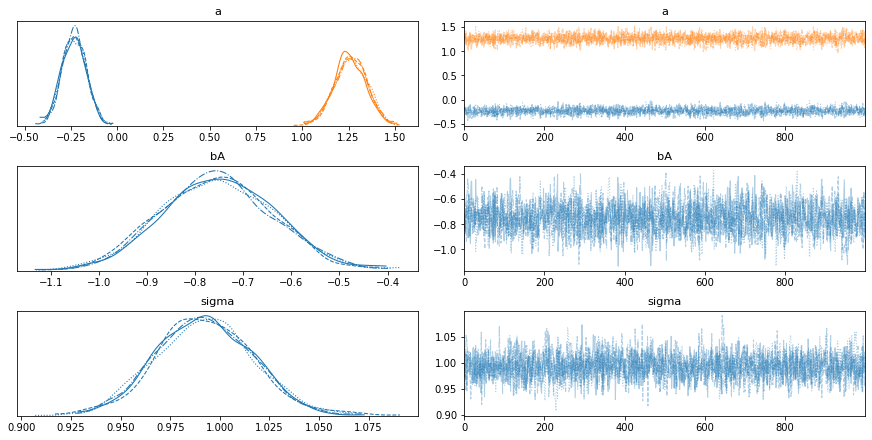

In [ ]:
pm.traceplot(trace_69);

In [ ]:
# Model 6.10 from the book:

with pm.Model() as model_610:
    # Data
    age = pm.Data("age", d["age"].values)
    happiness = pm.Data("happiness", d["happiness"].values)
    # Prior
    a = pm.Normal("a", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=2)
    sigma = pm.Exponential("sigma", lam=1)
    # Regression
    mu = a + bA * age
    happy_hat = pm.Normal("happy_hat", mu=mu, sd=sigma, observed=happiness)
    # Sampling
    prior_610 = pm.sample_prior_predictive(samples=30)
    trace_610 = pm.sample()
    posterior_610 = pm.sample_posterior_predictive(trace_610)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_610, credible_interval=0.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.15,0.15,0.0,0.0,2064.0,1558.0,2065.0,2107.0,1.0
bA,-0.00,0.13,-0.25,0.25,0.0,0.0,2023.0,1300.0,2024.0,2131.0,1.0
sigma,1.22,0.03,1.16,1.27,0.0,0.0,2038.0,2035.0,2053.0,1976.0,1.0


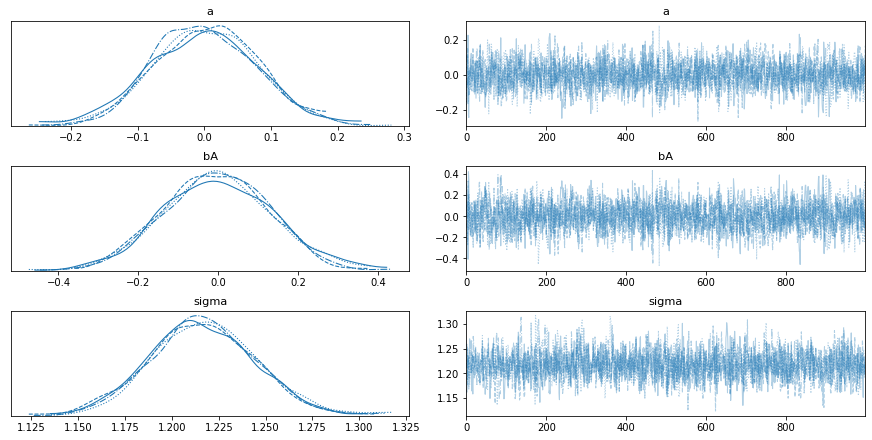

In [ ]:
pm.traceplot(trace_610);

In [ ]:
## Compare
pm.compare({"model 6.10": trace_610, "model 6.9": trace_69}, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model 6.9,0,-1.4e+03,3.7,0,1,14,0,False,log
model 6.10,1,-1.6e+03,2.3,1.9e+02,2.1e-66,18,18,False,log
